## Müller-Brown potential上でInstanton rate theoryの計算をしたい。
ポテンシャル関数

Müller-Brownポテンシャルは、以下の形式で記述されます：


$V(x, y) = \sum_{i=1}^4 A_i \exp\left[a_i (x - x_i)^2 + b_i (x - x_i)(y - y_i) + c_i (y - y_i)^2\right]$


ここで、 (x, y)  は座標空間上の点を表し、 $A_i ,  a_i ,  b_i ,  c_i ,  x_i ,  y_i$  は係数です。

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

In [4]:
class Potential(metaclass=ABCMeta):

    @abstractmethod
    def eval(self):
        pass

    @abstractmethod
    def gradient(self):
        pass

    @abstractmethod
    def gradient_2nd(self):
        pass

class MuellerBrown(Potential):

    A = np.array([-200, -100, -170, 15])
    a = np.array([-1, -1, -6.5, 0.7])
    b = np.array([0, 0, 11, 0.6])
    c = np.array([-10, -10, -6.5, 0.7])
    x0 = np.array([1, 0, -0.5, -1])
    y0 = np.array([0, 0.5, 1.5, 1])

    def __init__(self) -> None:
        pass

    def eval(self, p, A=A, a=a, b=b, c=c, x0=x0, y0=y0):
        if isinstance(p, tuple):
            raise NotImplementedError
        elif isinstance(p, np.ndarray):
            x_shifted = p[:,0,np.newaxis]-x0
            y_shifted = p[:,1,np.newaxis]-y0
            return np.dot(A, np.exp(a*(x_shifted)**2 + b*x_shifted*y_shifted + c*(y_shifted)**2).T)
        else:
            raise NotImplementedError

    def gradient(self, p, A=A, a=a, b=b, c=c, x0=x0, y0=y0):
        x_shifted = p[:,0,np.newaxis]-x0
        y_shifted = p[:,1,np.newaxis]-y0
        phi = np.exp(a*(x_shifted)**2 + b*x_shifted*y_shifted + c*(y_shifted)**2)
        part_x = np.dot(A, (phi*(2*a*x_shifted + b*y_shifted)).T)
        part_y = np.dot(A, (phi*(b*x_shifted + 2*c*y_shifted)).T)
        return (part_x, part_y)

    def gradient_2nd(self, p, A=A, a=a, b=b, c=c, x0=x0, y0=y0):
        x_shifted = p[:,0,np.newaxis]-x0
        y_shifted = p[:,1,np.newaxis]-y0
        phi = np.exp(a*(x_shifted)**2 + b*x_shifted*y_shifted + c*(y_shifted)**2)
        part_xx = np.dot(A, (phi*(2*a+(2*a*x_shifted + b*y_shifted)**2)).T)
        part_yy = np.dot(A, (phi*(2*c+(b*x_shifted + 2*c*y_shifted)**2)).T)
        part_xy = np.dot(A, (phi*(b+(2*a*x_shifted + b*y_shifted)*(b*x_shifted + 2*c*y_shifted))).T)
        return (part_xx, part_yy, part_xy)

    def plot_surface(self, *, p_list=None):
        x = np.linspace(-1.5, 0.8, 100)
        y = np.linspace(-0.3, 1.6, 100)
        X, Y = np.meshgrid(x, y)
        grids = np.array(list(zip(X.flatten(), Y.flatten())))
        energies = self.eval(grids).reshape(100, 100)
        plt.contourf(X, Y, energies, levels=40, cmap='jet')
        if p_list is not None:
            plt.scatter(p_list[:,0], p_list[:,1], c='red')
        plt.show()

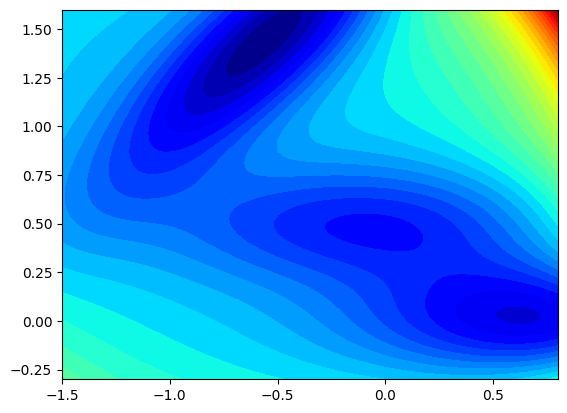

In [5]:
MB = MuellerBrown()
MB.plot_surface()

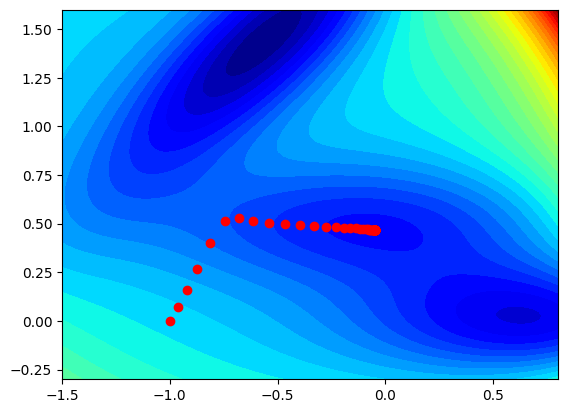

In [6]:
p_list = np.zeros((100, 2))
p_list[0] = (-1, 0)
MB = MuellerBrown()
for i in  range(p_list.shape[0]-1):
    #print(MB.energy(np.array([p_list[i]])))
    gx, gy = MB.gradient(np.array([p_list[i]]))
    p_list[i+1] = p_list[i] - 1e-3*np.array([gx[0], gy[0]])

MB.plot_surface(p_list=p_list)

In [40]:
class EuclideanAction():

    def __init__(self, *, potential=None):
        if potential is None:
            self.potential = MuellerBrown()
        else:
            self.potential = potential

    def eval(self, p_au, m_au=1, beta_hbar_au=1):
        N = p_au.shape[0]
        S = 0
        for i in range(N):
            idx1 = (i+N)%N
            idx2 = (i-1+N)%N
            disp = p_au[idx1]-p_au[idx2]
            S += 0.5*m_au*N/beta_hbar_au*np.dot(disp, disp.T)
        S += beta_hbar_au/N*np.sum(self.potential.eval(p_au))
        return S

    def gradient(self, p_au, m_au=1, beta_hbar_au=0.35):
        N = p_au.shape[0]
        S = np.zeros((N, 2))
        for i in range(N):
            idx1 = (i+N)%N
            idx2 = (i-1+N)%N
            idx3 = (i+1+N)%N
            S[i] = m_au*N/beta_hbar_au*(2*p_au[idx1]-p_au[idx2]-p_au[idx3]) + beta_hbar_au/N*np.array(self.potential.gradient(np.array([p_au[idx1]]))).flatten()
        return S

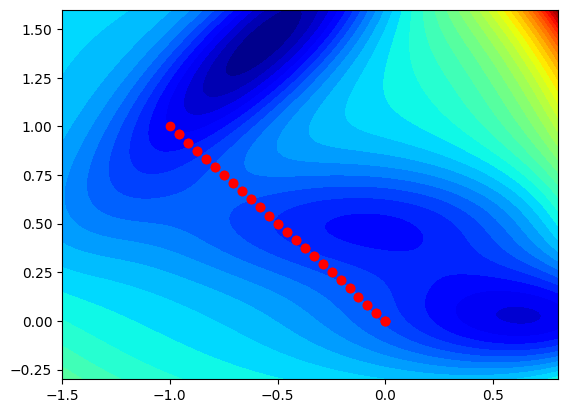

In [41]:
N = 50
RP = np.zeros((N, 2))
for i,j in enumerate(np.linspace(-1,0,25)):
    RP[i] = (j,-j)
    RP[-i] = (j,-j)
MB =MuellerBrown()
MB.plot_surface(p_list=RP)

-50.13357285686128 21.91431126710498
-50.40410086840153 16.36742907940248
-50.59646434949069 13.935930507568013
-50.75590757141655 12.620872206259623
-50.896589298419464 11.75071702606767
-51.0243276189177 11.098119058180876
-51.142202867301926 10.57464226718643
-51.25215787095814 10.138752187758183
-51.355553106957906 9.76735713930605
-51.45340298208835 9.445942658164588
-51.54649531392543 9.164597044751567
-51.63545980397141 8.916156956198304
-51.72081080999586 8.69523067775375
-51.802975727945714 8.497634083605003
-51.88231467986208 8.320041767301692
-51.95913464659097 8.159759680233073
-52.033699895280236 8.014570738029517
-52.1062398498925 7.882626415281154
-52.17695514717775 7.762368477918885
-52.24602237444321 7.652471114701651
-52.313597830286845 7.551797259510855
-52.379820548408645 7.4593650218303935
-52.444814756979625 7.374321468291836
-52.508691899698505 7.29592184974999
-52.571552312244165 7.223512929779281
-52.63348662473729 7.156519449073853
-52.69457694410721 7.0944330

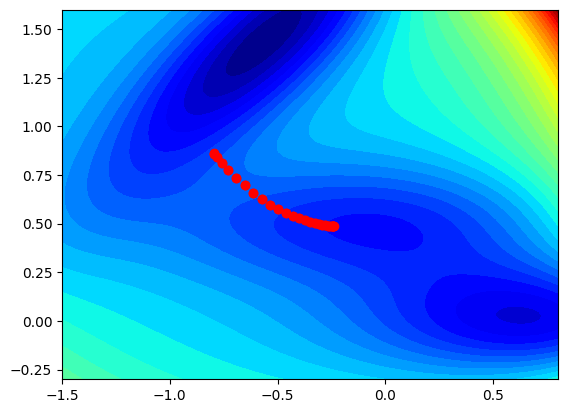

In [42]:
EA = EuclideanAction()
# print(EA.eval(RP))
# print(EA.gradient(RP))
RP_list = np.zeros((1000, N, 2))
RP_list[0] = RP
for i in range(RP_list.shape[0]-1):
    grad = EA.gradient(RP_list[i])
    RP_list[i+1] = RP_list[i]-1e-3*grad
    print(EA.eval(RP_list[i]), np.linalg.norm(grad.flatten()))

MB.plot_surface(p_list=RP_list[-1])